In [2]:
%matplotlib_svg
import pylab as pl
import numpy as np
from scipy import signal
np.set_printoptions(precision=3, linewidth=120, suppress=False)

## 频域信号处理

### FFT知识复习

In [18]:
x = np.random.rand(8)
xf = np.fft.fft(x)
print(x)
print(xf)

[ 0.361  0.419  0.499  0.558  0.031  0.705  0.419  0.314]
[ 3.307+0.j    -0.044-0.051j -0.526-0.252j  0.706+0.111j -0.686+0.j     0.706-0.111j -0.526+0.252j -0.044+0.051j]


In [19]:
np.fft.ifft(xf)

array([ 0.361 +0.000e+00j,  0.419 -1.032e-17j,  0.499 -1.388e-17j,  0.558 -1.076e-16j,  0.031 +0.000e+00j,
        0.705 +1.146e-16j,  0.419 +1.388e-17j,  0.314 +3.379e-18j])

In [20]:
x = np.ones(8)
np.fft.fft(x)/len(x) # 为了计算各个成分的能量，需要将FFT的结果除以FFT的长度

array([ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j])

In [22]:
x = np.arange(0, 2*np.pi, 2*np.pi/8)
y = np.sin(x)
tmp = np.fft.fft(y)/len(y)
print((np.array_str(tmp, suppress_small=True)))

[ 0.+0.j  -0.-0.5j  0.-0.j   0.-0.j   0.+0.j   0.-0.j   0.+0.j   0.+0.5j]


In [25]:
tmp = np.fft.fft(np.cos(x))/len(x)
print((np.array_str(tmp, suppress_small=True)))

[-0.0+0.j  0.5-0.j  0.0+0.j  0.0+0.j  0.0+0.j -0.0+0.j  0.0+0.j  0.5-0.j]


In [26]:
tmp = np.fft.fft(2*np.sin(2*x))/len(x)
print((np.array_str(tmp, suppress_small=True)))
tmp = np.fft.fft(0.8*np.cos(2*x))/len(x)
print((np.array_str(tmp, suppress_small=True)))

[ 0.+0.j  0.+0.j -0.-1.j  0.-0.j  0.+0.j  0.+0.j -0.+1.j  0.-0.j]
[-0.0+0.j -0.0+0.j  0.4-0.j  0.0-0.j  0.0+0.j  0.0-0.j  0.4+0.j -0.0+0.j]


In [27]:
x = np.arange(0, 2*np.pi, 2*np.pi/128)
y = 0.3*np.cos(x) + 0.5*np.cos(2*x+np.pi/4) + 0.8*np.cos(3*x-np.pi/3)
yf = np.fft.fft(y)/len(y)
print((np.array_str(yf[:4], suppress_small=True)))
print((np.abs(yf[1]), np.rad2deg(np.angle(yf[1])))) # 周期为128取样点的余弦波的振幅和相位
print((np.abs(yf[2]), np.rad2deg(np.angle(yf[2])))) # 周期为64取样点的余弦波的振幅和相位
print((np.abs(yf[3]), np.rad2deg(np.angle(yf[3])))) # 周期为42.667取样点的余弦波的振幅和相位

[ 0.000+0.j     0.150+0.j     0.177+0.177j  0.200-0.346j]
0.15 2.48480834489e-15
0.25 45.0
0.4 -60.0


In [28]:
x1 = np.random.random(4096)
x2 = np.random.random(4093)

%timeit np.fft.fft(x1)
%timeit np.fft.fft(x2)

10000 loops, best of 3: 183 µs per loop
10 loops, best of 3: 69.6 ms per loop


### 合成时域信号

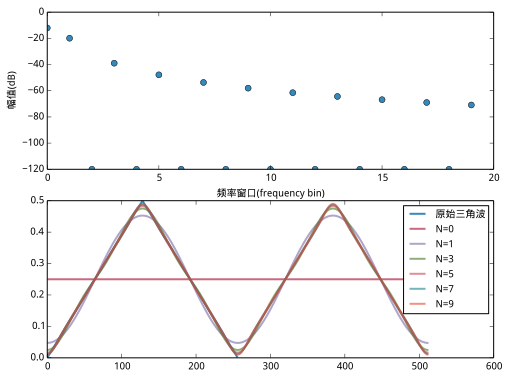

In [35]:
#%fig=三角波的频谱（上）、使用频谱中的部分频率重建的三角波（下）
def triangle_wave(size): #❶
    x = np.arange(0, 1, 1.0/size)
    y = np.where(x<0.5, x, 0)
    y = np.where(x>=0.5, 1-x, y)
    return x, y
    
# 取FFT计算的结果bins中的前n项进行合成，返回合成结果，计算loops个周期的波形
def fft_combine(bins, n, loops=1): #❷
    length = len(bins) * loops
    data = np.zeros(length)
    index = loops * np.arange(0, length, 1.0) / length * (2 * np.pi)
    for k, p in enumerate(bins[:n]):
        if k != 0: p *= 2 # 除去直流成分之外，其余的系数都*2
        data += np.real(p) * np.cos(k*index) # 余弦成分的系数为实数部
        data -= np.imag(p) * np.sin(k*index) # 正弦成分的系数为负的虚数部
    return index, data       

fft_size = 256

# 计算三角波和其FFT
x, y = triangle_wave(fft_size)
fy = np.fft.fft(y) / fft_size

# 绘制三角波的FFT的前20项的振幅，由于不含下标为偶数的值均为0， 因此取
# log之后无穷小，无法绘图，用np.clip函数设置数组值的上下限，保证绘图正确
fig, axes = pl.subplots(2, 1, figsize=(8, 6))
axes[0].plot(np.clip(20*np.log10(np.abs(fy[:20])), -120, 120), "o")
axes[0].set_xlabel("频率窗口(frequency bin)")
axes[0].set_ylabel("幅值(dB)")

# 绘制原始的三角波和用正弦波逐级合成的结果，使用取样点为x轴坐标
axes[1].plot(y, label="原始三角波", linewidth=2)
for i in [0,1,3,5,7,9]:
    index, data = fft_combine(fy, i+1, 2)  # 计算两个周期的合成波形
    axes[1].plot(data, label = "N=%s" % i, alpha=0.6)
axes[1].legend(loc="best");

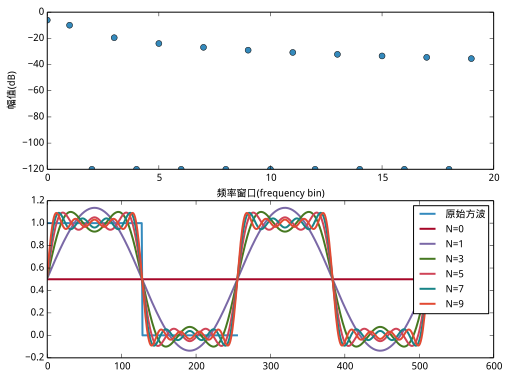

In [40]:
#%fig=方波的频谱、合成方波在跳变处出现抖动
def square_wave(size):
    x = np.arange(0, 1, 1.0/size)
    y = np.where(x<0.5, 1.0, 0)
    return x, y

x, y = square_wave(fft_size)
fy = np.fft.fft(y) / fft_size

fig, axes = pl.subplots(2, 1, figsize=(8, 6))
axes[0].plot(np.clip(20*np.log10(np.abs(fy[:20])), -120, 120), "o")
axes[0].set_xlabel("频率窗口(frequency bin)")
axes[0].set_ylabel("幅值(dB)")
axes[1].plot(y, label="原始方波", linewidth=2)
for i in [0,1,3,5,7,9]:
    index, data = fft_combine(fy, i+1, 2)  # 计算两个周期的合成波形
    axes[1].plot(data, label = "N=%s" % i)
axes[1].legend(loc="best");

> **SOURCE**

> `scpy2.examples.fft_demo`：使用该程序可以交互式地观察各种三角波和方波的频谱以及其正弦合成的近似波形

In [4]:
#%hide
%exec_python -m scpy2.examples.fft_demo

### 观察信号的频谱

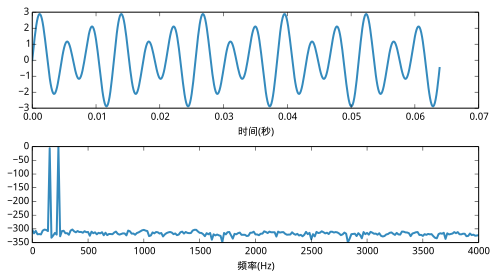

In [3]:
#%fig=156.25Hz和234.375Hz的波形（上）和频谱（下）
sampling_rate, fft_size = 8000, 512      #❶
t = np.arange(0, 1.0, 1.0/sampling_rate) #❷
x = np.sin(2*np.pi*156.25*t)  + 2*np.sin(2*np.pi*234.375*t) #❸

def show_fft(x):
    xs = x[:fft_size]
    xf = np.fft.rfft(xs)/fft_size #❹
    freqs = np.linspace(0, sampling_rate/2, fft_size/2+1) #❺
    xfp = 20*np.log10(np.clip(np.abs(xf), 1e-20, 1e100)) #❻
    pl.figure(figsize=(8,4))
    pl.subplot(211)
    pl.plot(t[:fft_size], xs)
    pl.xlabel("时间(秒)")
    pl.subplot(212)
    pl.plot(freqs, xfp)
    pl.xlabel("频率(Hz)")
    pl.subplots_adjust(hspace=0.4)
    
show_fft(x)

In [50]:
print((xfp[[10, 15]]))

[ -6.021e+00  -9.643e-16]


In [16]:
freqs = np.fft.fftfreq(fft_size, 1.0/sampling_rate)
for i in [0, 1, fft_size//2-1, fft_size//2, fft_size//2+1, fft_size-2, fft_size-1]:
    print((i, "\t", freqs[i]))

0 	0.0
1 	15.625
255 	3984.375
256 	-4000.0
257 	-3984.375
510 	-31.25
511 	-15.625


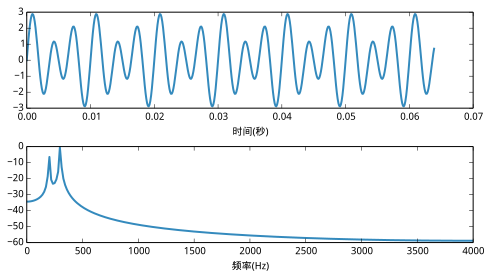

In [52]:
#%fig=非完整周期（200Hz和300Hz）的正弦波经过FFT变换之后出现频谱泄漏
x = np.sin(2*np.pi*200*t)  + 2*np.sin(2*np.pi*300*t)
show_fft(x)

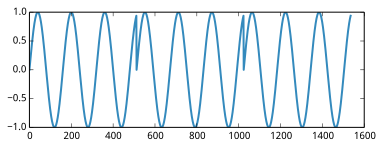

In [56]:
#%fig=50Hz正弦波的512点FFT所计算的频谱的实际波形
pl.figure(figsize=(6, 2))
t = np.arange(0, 1.0, 1.0/8000)
x = np.sin(2*np.pi*50*t)[:512]
pl.plot(np.hstack([x, x, x]));

#### 窗函数

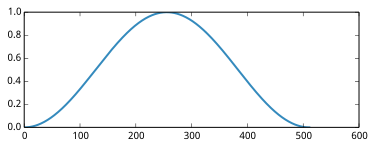

In [60]:
#%fig=Hann窗函数
from scipy import signal
pl.figure(figsize=(6, 2))
pl.plot(signal.hann(512));

In [61]:
print((signal.hann(8)))
print((signal.hann(8, sym=0)))

[ 0.     0.188  0.611  0.95   0.95   0.611  0.188  0.   ]
[ 0.     0.146  0.5    0.854  1.     0.854  0.5    0.146]


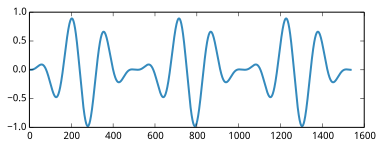

In [63]:
#%fig=加Hann窗的50Hz正弦波的512点FFT所计算的实际波形
pl.figure(figsize=(6, 2))
t = np.arange(0, 1.0, 1.0/8000)
x = np.sin(2*np.pi*50*t)[:512] * signal.hann(512, sym=0)
pl.plot(np.hstack([x, x, x]));

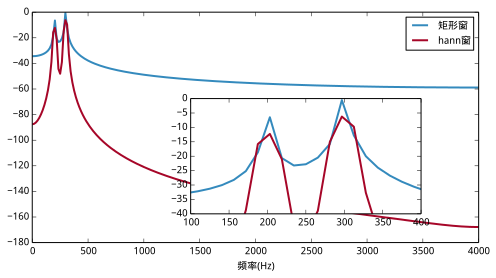

In [66]:
#%fig=加Hann窗前后的频谱，Hann窗能降低频谱泄漏
t = np.arange(0, 1.0, 1.0/sampling_rate)
x = np.sin(2*np.pi*200*t)  + 2*np.sin(2*np.pi*300*t)

xs = x[:fft_size] 
ys = xs * signal.hann(fft_size, sym=0)

xf = np.fft.rfft(xs)/fft_size
yf = np.fft.rfft(ys)/fft_size
freqs = np.linspace(0, sampling_rate/2, fft_size/2+1)
xfp = 20*np.log10(np.clip(np.abs(xf), 1e-20, 1e100))
yfp = 20*np.log10(np.clip(np.abs(yf), 1e-20, 1e100))
pl.figure(figsize=(8,4))
pl.plot(freqs, xfp, label="矩形窗")
pl.plot(freqs, yfp, label="hann窗")
pl.legend()
pl.xlabel("频率(Hz)")

a = pl.axes([.4, .2, .4, .4])
a.plot(freqs, xfp, label="矩形窗")
a.plot(freqs, yfp, label="hann窗")
a.set_xlim(100, 400)
a.set_ylim(-40, 0);

In [68]:
np.mean(signal.hann(512, sym=0))

0.5

#### 频谱平均

In [71]:
def average_fft(x, fft_size):
    n = len(x) // fft_size * fft_size
    tmp = x[:n].reshape(-1, fft_size)      #❶
    tmp *= signal.hann(fft_size, sym=0)    #❷
    xf = np.abs(np.fft.rfft(tmp)/fft_size) #❸
    avgf = np.mean(xf, axis=0)
    return 20*np.log10(avgf)

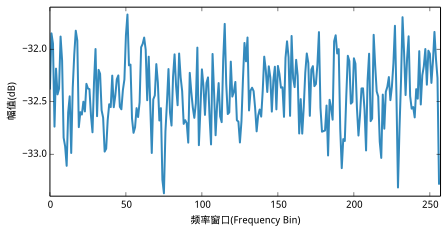

In [72]:
#%fig=白色噪声的频谱接近水平直线（注意Y轴的范围）
x = np.random.randn(100000)
xf = average_fft(x, 512)
pl.figure(figsize=(7,3.5))
pl.plot(xf)
pl.xlabel("频率窗口(Frequency Bin)")
pl.ylabel("幅值(dB)")
pl.xlim([0,257])
pl.subplots_adjust(bottom=0.15)

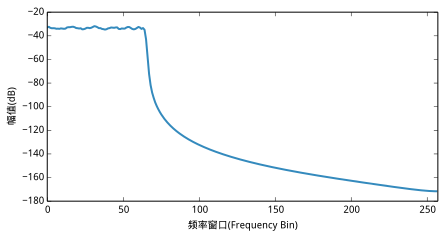

In [78]:
#%fig=经过低通滤波器的白噪声的频谱
b, a = signal.iirdesign(1000/4000.0, 1100/4000.0, 1, 40, 0, "cheby1")
x = np.random.randn(100000)
y = signal.filtfilt(b, a, x)
yf = average_fft(y, 512)
pl.figure(figsize=(7, 3.5))
pl.plot(yf)
pl.xlabel("频率窗口(Frequency Bin)")
pl.ylabel("幅值(dB)")
pl.xlim(0, 257)
pl.subplots_adjust(bottom=0.15)

#### 谱图

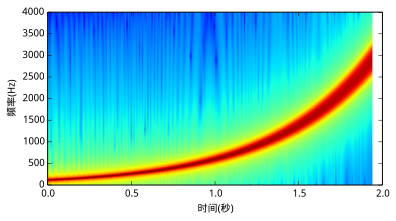

In [82]:
#%fig=频率扫描波的谱图
sampling_rate = 8000.0
fft_size = 1024
step = fft_size/16
time = 2

t = np.arange(0, time, 1/sampling_rate)
sweep = signal.chirp(t, f0=100, t1 = time, f1=0.8*sampling_rate/2, method="logarithmic")

pl.specgram(sweep, fft_size, sampling_rate, noverlap = 1024-step)
pl.xlabel("时间(秒)")
pl.ylabel("频率(Hz)");

> **SOURCE**

> `scpy2.examples.spectrogram_realtime`：实时观察声音信号谱图的演示程序，使用TraitsUI、PyAudio等库实现

In [6]:
#%hide
%exec_python -m scpy2.examples.spectrogram_realtime

#### 精确测量信号频率

In [3]:
def make_wave(amp, freq, phase, tend, rate):
    period = 1.0 / rate
    t = np.arange(0, tend, period)
    x = np.zeros_like(t)
    for a, f, p in zip(amp, freq, phase):
        x += a * np.sin(2*np.pi*f*t + p)
    return t, x

RATE = 8000
t, x = make_wave([1, 2, 0.5], [44, 150, 330], [1, 1.4, 1.8], 0.3, RATE)
x += np.random.randn(len(x))

In [4]:
FFT_SIZE = 1024
spect1 = np.fft.rfft(x[:FFT_SIZE] * np.hanning(FFT_SIZE))
freqs = np.fft.fftfreq(FFT_SIZE, 1.0/RATE)

bin_width = freqs[1] - freqs[0]

amp_spect1 = np.abs(spect1)
loc, = signal.argrelmax(amp_spect1, order=3) #❶
mask = amp_spect1[loc] > amp_spect1.mean() * 3   #❷
loc = loc[mask]
peak_freqs = freqs[loc]
print(("bin width:", bin_width))
print(("Peak Frequencies:", peak_freqs))

bin width: 7.8125
Peak Frequencies: [  46.875  148.438  328.125]


In [5]:
COUNT = FFT_SIZE//4
dt = COUNT / 8000.0

spect2 = np.fft.rfft(x[COUNT:COUNT+FFT_SIZE] * np.hanning(FFT_SIZE))

phase1 = np.angle(spect1[loc])
phase2 = np.angle(spect2[loc])

phase_delta = phase2 - phase1
print(phase_delta)

[ 2.595 -1.29  -2.899]


In [7]:
max_n = (peak_freqs.max() + 3*bin_width) * dt #❶
n = np.arange(max_n)

possible_freqs = (phase_delta + 2*np.pi*n[:, None]) / (2 * np.pi * dt) #❷

idx = np.argmin(np.abs(peak_freqs - possible_freqs), axis=0)   #❸
peak_freqs2 = possible_freqs[idx, np.arange(len(peak_freqs))]  
print(("Peak Frequencies:", peak_freqs2))

Peak Frequencies: [  44.155  149.833  329.33 ]


### 卷积运算

#### 快速卷积

In [8]:
def fft_convolve(a,b):
    n = len(a) + len(b) - 1
    N = 2**(int(np.log2(n)) + 1)  #❶
    A = np.fft.fft(a, N)          #❷
    B = np.fft.fft(b, N)
    return np.fft.ifft(A * B)[:n] #❸

a = np.random.rand(128)
b = np.random.rand(128)
c = np.convolve(a,b)
np.allclose(c, fft_convolve(a, b))

True

In [9]:
a=np.random.rand(10000)
b=np.random.rand(10000)
print np.allclose(np.convolve(a, b), fft_convolve(a, b))

%timeit np.convolve(a, b)
%timeit fft_convolve(a, b)

True
10 loops, best of 3: 36.5 ms per loop
100 loops, best of 3: 6.43 ms per loop


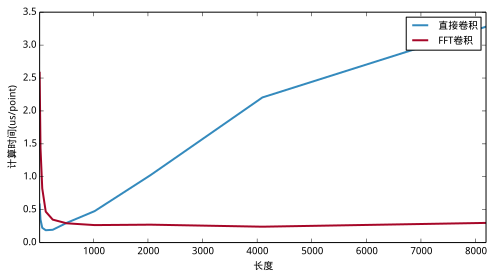

In [60]:
#%fig=比较直接卷积和FFT卷积的运算速度
results = []
for n in xrange(4, 14):
    N = 2**n
    a = np.random.rand(N)
    b = np.random.rand(N)
    tr1 = %timeit -r 1 -o -q np.convolve(a, b)
    tr2 = %timeit -r 1 -o -q fft_convolve(a, b)
    t1 = tr1.best * 1e6 / N
    t2 = tr2.best * 1e6 / N
    results.append((N, t1, t2))
results = np.array(results)

pl.figure(figsize=(8,4))
pl.plot(results[:, 0], results[:, 1], label=u"直接卷积")
pl.plot(results[:, 0], results[:, 2], label=u"FFT卷积")
pl.legend()
pl.ylabel(u"计算时间(us/point)")
pl.xlabel(u"长度")
pl.xlim(min(n_list),max(n_list));

#### 卷积的分段运算

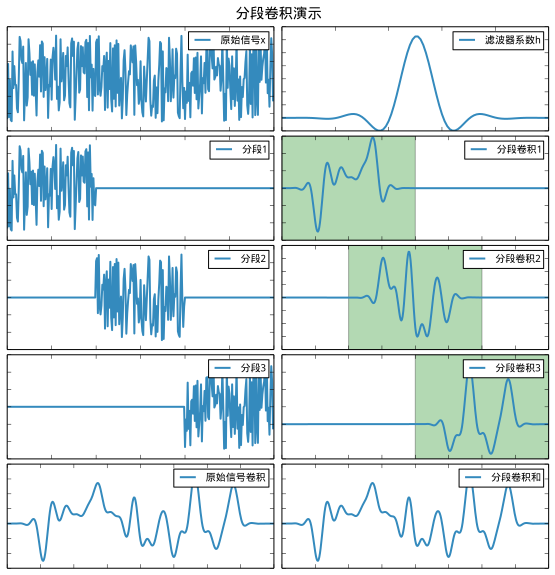

In [64]:
#%figonly=使用overlap-add法进行分段卷积的过程演示
def windowed_sinc(fc, M, K):
    i = np.arange(0,M,1.0)
    h = K * np.sin(2*np.pi*fc*(i-M/2.0))/(i-M/2.0)
    h *= 0.42 - 0.5*np.cos(2*np.pi*i/M) + 0.08*np.cos(4*np.pi*i/M)
    return h
    
x = np.random.rand(300) - 0.5   
h = windowed_sinc(0.05, 101, 1.0)

xs = []
for i in range(3):
    tmp = np.zeros(len(x), dtype=np.float64)
    tmp[i*100:i*100+100] = x[ i*100:i*100+100 ]
    xs.append(tmp)

y = np.convolve(x,h)
fig = pl.figure(figsize=(8, 8))

pl.subplot(521)
pl.plot(x, label="原始信号x")
pl.gca().set_yticklabels([])
pl.gca().set_xticklabels([])
pl.legend()

pl.subplot(522)
pl.plot(h, label="滤波器系数h")
pl.gca().set_yticklabels([])
pl.gca().set_xticklabels([])
pl.legend()

result = []
for i,tmp in enumerate(xs):
    pl.subplot(520+3+i*2)
    pl.plot(tmp, label="分段%s" % (i+1))
    pl.gca().set_yticklabels([])
    pl.gca().set_xticklabels([])
    pl.legend()
    pl.subplot(520+3+i*2+1)
    tmp = np.convolve(tmp, h)
    result.append(tmp)
    pl.plot(tmp, label="分段卷积%s" % (i+1))
    pl.gca().set_yticklabels([])
    pl.gca().set_xticklabels([])  
    pl.axvspan(i*100,i*100+200,alpha=0.3,facecolor="g")
    pl.legend()

pl.subplot(529)
pl.plot(np.convolve(x,h), label="原始信号卷积")
pl.gca().set_yticklabels([])
pl.gca().set_xticklabels([])  
pl.legend()

pl.subplot(5,2,10)
pl.plot(np.sum(result, axis=0), label="分段卷积和")
pl.gca().set_yticklabels([])
pl.gca().set_xticklabels([]) 
pl.legend()

pl.subplots_adjust(hspace=0.05, wspace=0.03, top=0.95, bottom=0.01,left=0.03,right=0.97)
pl.figtext(0.5, 0.965,  "分段卷积演示",
           ha='center', color='black', weight='bold', size='large');

In [67]:
x = np.random.rand(1000)
h = np.random.rand(101)
y = np.convolve(x, h)

N = 50 # 分段大小
M = len(h) # 滤波器长度

output = []

#缓存初始化为0
buffer = np.zeros(M+N-1,dtype=np.float64)

for i in range(len(x)/N):
    #从输入信号中读取N个数据
    xslice = x[i*N:(i+1)*N]
    #计算卷积
    yslice = np.convolve(xslice, h)
    #将卷积的结果加入到缓冲中
    buffer += yslice
    #输出缓存中的前N个数据，注意使用copy，否则输出的是buffer的一个视图
    output.append( buffer[:N].copy() ) #❶
    #缓存中的数据左移动N个元素
    buffer[0:-N] = buffer[N:]
    #后面的补0
    buffer[-N:] = 0

#将输出的数据组合为数组
y2 = np.hstack(output)
#计算和直接卷积的结果之间的误差
print(("error:", np.max(np.abs( y2 - y[:len(x)] ) )))

error: 7.1054273576e-15
